# Error calculus of calibrated thermocouples

# Imports

In [2]:
import numpy as np
from utilities.data.lvm import lvm_to_df
# Données d'étalonnage
import pandas as pd
from scipy.optimize import least_squares
from scipy.stats import chi2 
from CoolProp.CoolProp import PropsSI 
from tqdm import tqdm
import matplotlib.pyplot as plt
import pyerrors as pe

## Get data

<Axes: >

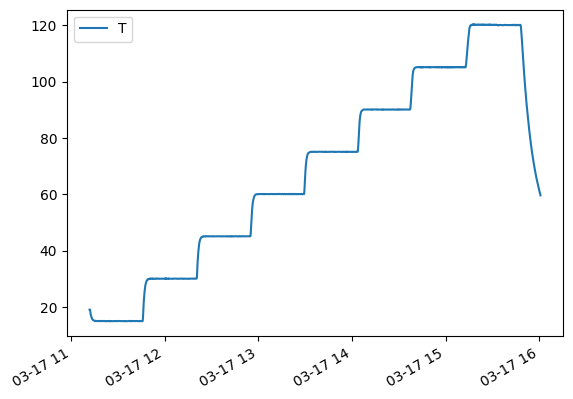

In [3]:
#Exexmple données réelles
df = lvm_to_df(r'C:\Users\yberton\OneDrive - INSA Lyon\Expérimental\Acquisition\Etalonnage\E_in_imm\17_03_2025.lvm')
df_et = pd.DataFrame({"T" : df['202 - E_in_imm [°C]']})
df_et.plot()


# Measures treatments

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""\
The idea here is to get rid of the transition period in between two calibration points \
In order to do so, a standart deviation calculus is realized for each temperature value over the four last values \
If it is under a certain value to be defined by the user, then the measure is erased

Let's make sure that the steady state was reached !


In [4]:

#Get the serie time step
dt = df_et.index[1] - df_et.index[0]
dt = dt.seconds + dt.microseconds*10e-6 + dt.nanoseconds*10e-9 # [seconds]
t_step = 60*5 # Time step for steady state conditions in the rolling(std) method of df [seconds]


In [5]:

# Get the temperature used for the calibration from user
# Temperatures used for the calibration
LT = [15,30,45,60,75,90,105,120]

## Cut the data to surrender the temperatures of reference

In [6]:

# We find in between temp in order to split the dataframe in several ones for a giver reference temmperature
LT_to_sort = [(LT[i] + LT[i+1])/2 for i in range(0, 7)]
df_to_sort = df_et.copy()

Ldfs = []  # Initializing list of dataframe
for Tmax in LT_to_sort:
    df_left = df_to_sort[df_to_sort.iloc[:, 0] < Tmax]  # Cut data to add to the dataframe list
    df_to_sort = df_to_sort[df_to_sort.iloc[:, 0] >= Tmax]  # Cut this data from df
    Ldfs.append(df_left)  # Append the cut dataframe to the list of dataframe
# Finally, append the remaing data in df as the last dataframe of the list
Ldfs.append(df_to_sort)

In [7]:
df_et

,T
2025-03-17 11:12:00.912390,19.073353
2025-03-17 11:12:10.912390,19.066837
2025-03-17 11:12:20.912390,19.092676
2025-03-17 11:12:30.912390,18.185490
2025-03-17 11:12:40.912390,17.554129
...,...
2025-03-17 16:00:00.912390,61.023769
2025-03-17 16:00:10.912390,60.752750
2025-03-17 16:00:20.912390,60.323978
2025-03-17 16:00:30.912390,60.080757


## Calculate the average temperature for steady state data

In [8]:

Ldf_treated = []  # Initialization of treated list of dataframes
LTmean = []  # Initialization of Tmean array

std_lim = 0.001
std_buff = std_lim
Lstd= []
for i in tqdm(range(len(Ldfs))):  # Going through all the dataframes for each temperature test
    df = Ldfs[i]  # Get the dataframe

    # Let's make sure that the steady state was reached
    # Get a standart deviation for a period set by the user through t_step
    df_std = df.rolling(round(t_step/dt)).std()
    cols = [col for col in df_std.columns]  # get columns' names in a array
    # Create new cols names
    new_cols = [col + '_std' for col in df_std.columns]

    # Add the std values to the first dataframe
    for i in tqdm(range(0, len(new_cols))):
        df[new_cols[i]] = df_std[cols[i]]

    # Delete the lines where std < std_lim
    for i in tqdm(range(int(len(df.columns)/2), int(len(df.columns)))):
        std_buff = std_lim
        df_buff = df[df.iloc[:, i] < std_lim]
        while len(df_buff) <= 20:
            std_buff += 0.01
            df_buff = df[df.iloc[:, i] < std_buff] 
            if std_buff > 1:
                break
        df = df_buff.copy()
        Lstd.append(std_buff)
            
    Tmean = []
    # Get the average value
    for i in tqdm(range(0, int(len(df.columns)/2))):
        Tmean.append(df.iloc[:, i].mean())

    # Add the treated dataframe to a list
    Ldf_treated.append(df)

    # Add the mean temperature to a list
    LTmean.append(Tmean)

100%|██████████| 8/8 [00:00<00:00, 45.16it/s]


# Calibration of the thermocouple : f = a.x + b

### Calibration data

In [9]:
#####ETALONNAGE#####
# Exemple de données d'étalonnage (en K)
x = np.array(LT)  # Températures de référence
yik = [ser.iloc[:,0].to_numpy() for ser in Ldf_treated]
n = [len(yi) for yi in yik]
m = len(x) # Ici = 8
N = sum(n)
yi = np.array(LTmean)  # Températures mesurées par le thermocouple
y_bar = sum([sum(j) for j in yik])/N 
x_bar = sum([n[i]*x[i] for i in range(m)])/N

### Linear regression

In [10]:
# Régression linéaire
a, b = np.polyfit(y=yi, x=x, deg=1)
y_chap = a*yi + b 


### si² calculation

In [11]:
Lsi2 = []
for i in range(0,m):
    si2 = 0
    for k in range(0,n[i]):
        si2 += (1/(n[i] - 1) * (yik[i][k] - np.mean(yik[i]))**2)
    Lsi2.append(si2)
Lsi2 = np.array(Lsi2)

### gi calculation

It is necessary to calculate the gi values since the previous Si are not constants. A ponderation is necessary.

In [12]:
K = 1 #POURQUOIIII ? PARCE QUE
w = K/Lsi2


### Calculation of $a_{0}$, $b_{0}$, $s_{A}$, $s_{B}$

#### Calculation of $\Delta$

In [13]:
sum1 = sum2 = sum3 = sum4 = sum5 = 0
for i in range(m):

    sum1 += w[i]
    sum2 += w[i]*x[i]**2
    sum3 += w[i]*x[i]
    sum4 += w[i]*yi[i]
    sum5 += w[i]*x[i]*yi[i]

delta = sum1*sum2 - sum3**2
a0 = ((sum2*sum4)-(sum3*sum5))/delta
b0 = ((sum1*sum5) - (sum3*sum4))/delta
sa2 = sum2/delta
sb2 = sum1/delta

In [14]:
print(f"""
a0 = {a0} ; Sa = {np.sqrt(sa2)}
b0 = {b0} ; Sb = {np.sqrt(sb2)}
""")


a0 = [0.04024428] ; Sa = 0.023475724558505336
b0 = [1.00064375] ; Sb = 0.0003340409110923385



### Standard uncertainty

In [15]:
sy2 = ((1)/(m-2)*sum([(yi[i] - (a0 + b0*x[i]))**2 for i in range(m)]))

In [16]:
res = np.polyfit(x=x,y=yi,deg=1)

In [17]:
print(res)

[[1.00063864]
 [0.0412964 ]]


## Linearity check

### $\chi^{2}$ calculation

In [18]:
chi2_etal = sum( [(yi[i] - (a0 + b0*x[i]))**2/(si2) for i in range(m)] )

In [19]:
chi2_etal

array([1.12049259])

### $\chi_{r}^{2}$ calculation

In [20]:
chir2 = chi2_etal/(m-2)

In [21]:
chir2

array([0.18674877])

### Calculation of the statistic and systematic errors $y_{0}$ and $y'_{0}$

## Steady state data acquisition

In [26]:
#####BASE DE DONNEES INDEPENDANTE ETALONNAGE#####
xmes = lvm_to_df(r".\exemples\PPh_359.lvm").filter(['202 - E_in_imm [°C]'],axis=1) # Températures de test - essai en RP
Pmes = lvm_to_df(r".\exemples\PPh_359.lvm").filter(['118 - P_TS_in [bars]']).values*10E5
lvm_to_df(r".\exemples\PPh_359.lvm").filter(['202 - E_in_imm [°C]'],axis=1).plot.scatter(0:,0)
nmes = len(df)

SyntaxError: invalid syntax (3995903865.py, line 4)

### ${S'}_{y}^{2}$ calculation

In [ ]:
# Systematic error
spy2 = sy2/b0**2
print(f'spy2 : {spy2[0]}')

spy2 : 0.0004542387792836172


In [ ]:
# Statistic error
sx2_typeA = ((xmes - xmes.mean())**2).sum()/nmes
print(f'sx2_typeA : {sx2_typeA.values[0]}')

sx2_typeA : 0.000903089570925292


### $S_{y, A}^{2}$ calculation

In [ ]:
sya2 = sx2_typeA/(b0**2)
print(f'sya2 : {sya2.values[0]}')

sya2 : 0.0009019279687965499


### Total error over the measure $S^{2}_{tot}$ = $S_{y, A}^{2}$ + ${S'}_{y}^{2}$


In [ ]:
stot2 = sya2 + spy2
ybar = xmes.mean()
print(f'T̄ = {ybar.values[0]} ± {np.sqrt(stot2.values[0])}')

T̄ = 97.61789956666665 ± 0.03682616933758068


In our case, the linear calibration of the thermocouples method results in a $\chi_{r}^{2}$ value of 0.188.
This value is inferior to one, showing that the uncertainties have been over estimated.
Since the uncertainty is around 0.02 K, we found this correction sufficient and decide to go forward the propagation of error by simulations of Monte Carlo.
This movie has been directed by Yoann Seyve and Yann Berton. Copryrighted. All rights exclusive.

## Monte Carlo

### Measures and errors

In [ ]:
Pmes = Pmes.mean()
Tmes = ybar
uTmes = np.sqrt(stot2.values[0])
uPmes = 60E+2


### Confidence level

In [ ]:
nc = 95/100
a = nc ; b = 2 - nc
print(f'a = {a} ; b = {b}')

a = 0.95 ; b = 1.05


In [ ]:
delta = b**2 - a**2

### Calculation by iteration of the number of samples - Condition on $\chi²$

In [ ]:
nu = 1
diff = (chi2.ppf(0.975,nu) - chi2.ppf(0.025,nu))/nu
while (0.9999 <= diff/delta <= 1.0001) == False:
    nu += 1
    diff = (chi2.ppf(0.975,nu) - chi2.ppf(0.025,nu))/nu
print(f'nu = {nu} ; diff/delta = {diff/delta}')

nu = 768 ; diff/delta = 0.9999615260729126


### Random population initialization for Tmes and Pmes

In [ ]:
Pmc = np.random.normal(loc = Pmes, scale =uPmes, size=nu+1)
#np.random.seed(48)
Tmc = np.random.normal(loc = Tmes, scale =uTmes, size=nu+1)

### Calculation of statistics variables around the generated samples of Tmc

In [ ]:
### Statistic variables around the N generated samples
mean_Pmc = Pmc.mean()
var2_Pmc = sum([(pmc - mean_Pmc)**2/(N-1) for pmc in Pmc])
std_Pmc = np.std(Pmc)
print(f'std_Pmc : {std_Pmc}')

std_Pmc : 6191.490932725184


### Calculation of statistics variables around the generated samples of Tmc

In [ ]:
### Statistic variables around the N generated samples
mean_Tmc = Tmc.mean()
var2_Tmc = sum([(tmc - mean_Tmc)**2/(N-1) for tmc in Tmc])
std_Tmc = np.std(Tmc)
print(f'std_Tmc : {std_Tmc}')

std_Tmc : 0.036603977421274886


In [ ]:
len(Tmc)

769

### Covariances calculation to make sure we have found the good size for the population sample
Assess the independance of the variables

In [ ]:
cov_PT = np.cov(Pmc,Tmc,ddof=1)

In [ ]:
cov_PT = cov_PT[0, 1]

### Error calculation of a combination of P and T

In [ ]:
H = lambda P,T : PropsSI('H', 'P', P, 'T', T+273.15, 'R245fa')
Hmc = H(Pmc,Tmc)

### Plot : Hmc = f(Tmc)

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

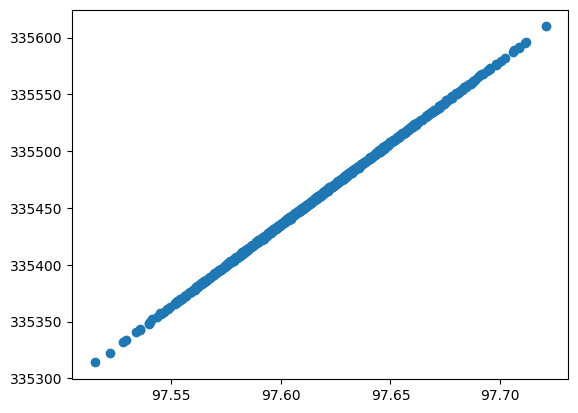

In [ ]:
fig,ax = plt.subplots(1,1)
ax.scatter(Tmc, Hmc)
plt.plot

### Statistic calculations over Hmc

In [ ]:
print(f"""
Hmc_mean = {Hmc.mean()} J/kg
Hmc_std = {Hmc.std()} J/kg
Hmc = {Hmc.mean()} ± {Hmc.std()*2} (cad : err = {Hmc.std()*2/Hmc.mean()*100} %)
""")


Hmc_mean = 335460.1046578907 J/kg
Hmc_std = 52.71511587907272 J/kg
Hmc = 335460.1046578907 ± 105.43023175814544 (cad : err = 0.031428545539167886 %)



### Test pyerrors

In [ ]:
obs1 = pe.Obs([Pmc], ['ensemble1'])
obs2 = pe.Obs([Tmc], ['ensemble1'])

In [ ]:
Hmc = fun(obs1,obs2)

NameError: name 'fun' is not defined

In [ ]:
type(Hmc)

float

In [ ]:
obs3 = pe.Obs([H(Pmc,Tmc)], ['ensemble2'])

In [ ]:
type(obs3)

pyerrors.obs.Obs

In [ ]:
obs3.gamma_method()
print(obs3)

335461.7(2.0)


In [ ]:
exp = f"H(Pmc,Tmc)"
a = eval(exp)
print(a)

[335408.028919   335404.31262433 335426.62511301 335516.81780454
 335452.39248158 335519.4974835  335350.81487879 335498.53364933
 335550.06438644 335440.39564396 335583.88782253 335408.33172263
 335431.46590602 335355.46904497 335441.31580143 335393.63154873
 335569.766862   335491.93178003 335544.21005008 335559.24536977
 335401.82169897 335379.72470236 335548.77796245 335413.77138633
 335481.16551087 335436.09021292 335466.06624114 335438.58571726
 335483.80192834 335431.79570041 335507.37629992 335422.27140591
 335510.99433452 335392.50039289 335436.36784658 335409.32444687
 335474.6636943  335431.23988842 335493.7478651  335476.12760241
 335411.33367031 335431.83539817 335455.94715943 335441.95779577
 335465.46564155 335486.53778244 335462.83644913 335514.12508778
 335421.80072519 335538.16216839 335411.34805849 335541.89801727
 335502.62577414 335543.15285028 335536.19757571 335548.54875862
 335390.02615609 335396.35461455 335420.50547557 335529.18125193
 335604.40829819 335431.4